Data source - https://www.kaggle.com/datasets/ganiyuolalekan/spam-assassin-email-classification-dataset

Load and prepare data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random, torch

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# If using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For multi-GPU if applicable

# Additional settings for full determinism (optional but recommended)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
df = pd.read_csv("spam_assassin.csv", encoding="utf-8")
y = df["target"].values
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5796 non-null   object
 1   target  5796 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


In [3]:
# Class distribution
df["target"].value_counts()

,count
target,
0,3900
1,1896


In [4]:
# Length features
df["char_len"] = df["text"].astype(str).str.len()
df["word_len"] = df["text"].astype(str).str.split().str.len()

print(df[["target", "text", "char_len", "word_len"]].head())
# char_len: number of characters in each message.
# word_len: number of words in each message.

   target                                               text  char_len  \
0       0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...      4098   
1       1  From gort44@excite.com Mon Jun 24 17:54:21 200...      2195   
2       1  From fork-admin@xent.com Mon Jul 29 11:39:57 2...      3600   
3       1  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...      1946   
4       0  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...      3068   

   word_len  
0       558  
1       295  
2       386  
3       153  
4       399  


In [5]:
print(df["char_len"].describe())

count      5796.000000
mean       4226.862146
std        5908.069980
min         362.000000
25%        2423.000000
50%        3328.000000
75%        4539.500000
max      232329.000000
Name: char_len, dtype: float64


In [6]:
print(df["word_len"].describe())

count     5796.000000
mean       451.447550
std        533.935556
min         45.000000
25%        258.750000
50%        355.000000
75%        497.000000
max      15164.000000
Name: word_len, dtype: float64


Plot histogram for word length

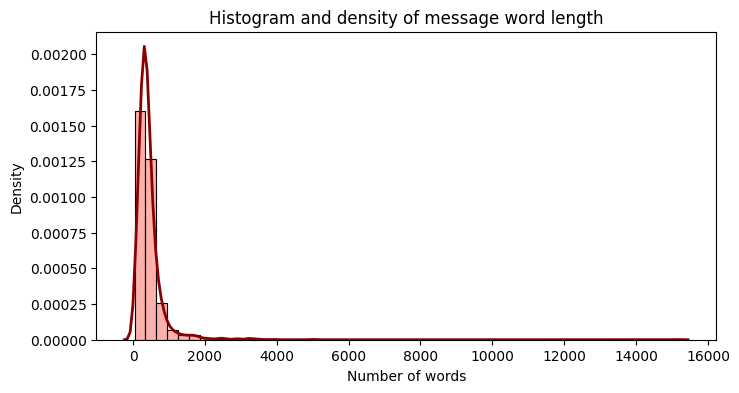

In [7]:
plt.figure(figsize=(8,4))

# Histogram (normalized to probability density)
sns.histplot(df["word_len"], bins=50, stat="density", color="salmon", edgecolor="black", alpha=0.6)

# KDE line on top
sns.kdeplot(df["word_len"], color="darkred", linewidth=2)

plt.title("Histogram and density of message word length")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.show()

Plot histogram for character length

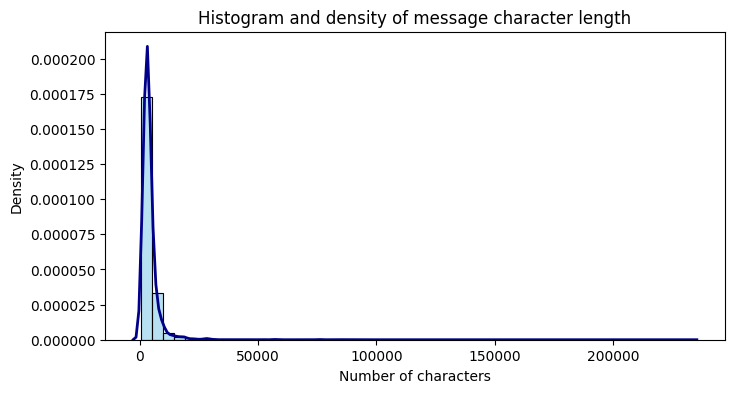

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure char_len exists
df["char_len"] = df["text"].astype(str).str.len()

plt.figure(figsize=(8,4))

# Histogram of character length, normalised
sns.histplot(df["char_len"], bins=50, stat="density",
             color="skyblue", edgecolor="black", alpha=0.6)

# Density (line) on top
sns.kdeplot(df["char_len"], color="darkblue", linewidth=2)

plt.title("Histogram and density of message character length")
plt.xlabel("Number of characters")
plt.ylabel("Density")
plt.show()

Box Plots

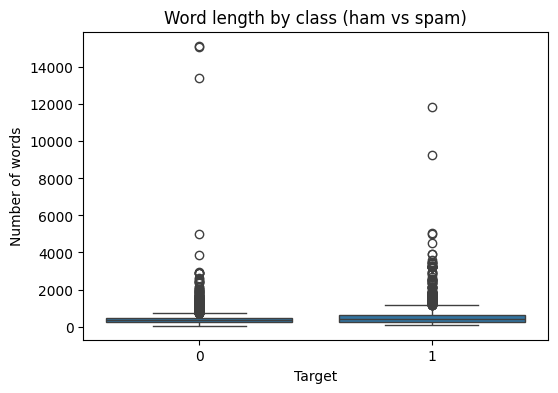

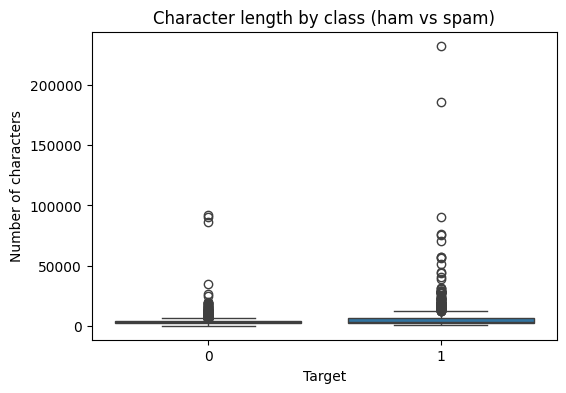

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of word length by label
plt.figure(figsize=(6,4))
sns.boxplot(x="target", y="word_len", data=df)
plt.title("Word length by class (ham vs spam)")
plt.xlabel("Target")
plt.ylabel("Number of words")
plt.show()

# Boxplot of character length by label (optional second plot)
plt.figure(figsize=(6,4))
sns.boxplot(x="target", y="char_len", data=df)
plt.title("Character length by class (ham vs spam)")
plt.xlabel("Target")
plt.ylabel("Number of characters")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X = df["text"].values
y = df["target"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [13]:
import re
from collections import Counter

def clean_text(text):
    """
    Text cleaning optimized for spam detection
    Preserves important spam signals while normalizing text
    """
    # Convert to string (handle any non-string values)
    text = str(text)

    # 1. Normalize whitespace (remove extra spaces, tabs, newlines)
    text = re.sub(r'\s+', ' ', text)

    # 2. Remove leading/trailing whitespace
    text = text.strip()

    # 3. Convert to lowercase
    text = text.lower()

    return text

def tokenize(text):
    """
    Tokenize cleaned text into words
    Extracts only alphanumeric words
    """
    # First clean the text
    text = clean_text(text)

    # Extract words (alphanumeric sequences)
    tokens = re.findall(r"\b\w+\b", text)

    return tokens

def build_vocab(texts, min_freq=2, max_size=5000):
    """
    Build vocabulary from texts

    Args:
        texts: list of text strings
        min_freq: minimum frequency for a word to be included
        max_size: maximum vocabulary size

    Returns:
        stoi: string to index mapping (dict)
        itos: index to string mapping (list)
    """
    counter = Counter()

    # Count word frequencies
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)

    # Start with special tokens
    itos = ["<PAD>", "<UNK>"]

    # Add most common words up to max_size
    for word, freq in counter.most_common():
        if freq < min_freq:
            break
        if len(itos) >= max_size:
            break
        itos.append(word)

    # Create reverse mapping
    stoi = {word: idx for idx, word in enumerate(itos)}

    return stoi, itos

# Build vocabulary from training data
print("="*70)
print("BUILDING VOCABULARY WITH IMPROVED CLEANING")
print("="*70)

stoi, itos = build_vocab(X_train, min_freq=2, max_size=10000)
vocab_size = len(itos)

print(f"\n✓ Vocabulary built successfully")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Special tokens: <PAD> (index 0), <UNK> (index 1)")
print(f"\nSample vocabulary (first 20 words):")
for i in range(min(20, len(itos))):
    word = itos[i]
    if word not in ["<PAD>", "<UNK>"]:
        count = sum(1 for text in X_train if word in tokenize(text))
        print(f"  {i:3d}: '{word}' (appears in {count} emails)")

print("\nBefore and after cleaning:")
# Define sample_texts using X_train
sample_texts = X_train[:3]
for text in sample_texts:
    cleaned = clean_text(text)
    tokens = tokenize(text)
    print(f"\nOriginal: {text}")
    print(f"Cleaned:  {cleaned}")
    print(f"Tokens:   {tokens[:10]}")  # Show first 10 tokens

print("\n" + "="*70)

# Set maximum sequence length
max_len = 200

def encode(text, stoi, max_len=max_len):
    """
    Encode text to sequence of indices

    Args:
        text: input text string
        stoi: string to index mapping
        max_len: maximum sequence length

    Returns:
        numpy array of token indices
    """
    # Tokenize with cleaning
    tokens = tokenize(text)

    # Convert tokens to indices
    ids = [stoi.get(token, stoi["<UNK>"]) for token in tokens]

    # Truncate if too long
    ids = ids[:max_len]

    # Pad if too short
    if len(ids) < max_len:
        ids = ids + [stoi["<PAD>"]] * (max_len - len(ids))

    return np.array(ids, dtype=np.int64)

# Encode all datasets
print("\n" + "="*70)
print("ENCODING DATASETS")
print("="*70)

X_train_ids = np.stack([encode(text, stoi) for text in X_train])
X_val_ids = np.stack([encode(text, stoi) for text in X_val])
X_test_ids = np.stack([encode(text, stoi) for text in X_test])

# Ensure labels are float32
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"\n✓ Encoding complete")
print(f"  Training samples: {X_train_ids.shape[0]}")
print(f"  Validation samples: {X_val_ids.shape[0]}")
print(f"  Test samples: {X_test_ids.shape[0]}")
print(f"  Sequence length: {max_len}")

# Show encoding example
print("\n" + "="*70)
print("ENCODING EXAMPLE")
print("="*70)

sample_text = X_train[0]
sample_tokens = tokenize(sample_text)
sample_encoded = encode(sample_text, stoi)

print(f"\nOriginal text: {sample_text[:100]}...")
print(f"\nTokens: {sample_tokens[:15]}")
print(f"\nEncoded (first 15): {sample_encoded[:15]}")
print(f"Decoded (first 15): {[itos[idx] for idx in sample_encoded[:15]]}")

print("\n" + "="*70)
print("TEXT CLEANING COMPLETE!")
print("="*70)
print("\nCleaning steps applied:")
print("  1. ✓ Whitespace normalization")
print("  2. ✓ Lowercase conversion")
print("  3. ✓ Word tokenization (alphanumeric only)")
print("  4. ✓ Vocabulary building (min_freq=2, max_size=5000)")
print("  5. ✓ Sequence encoding and padding")
print("\nNote: Punctuation and numbers are removed during tokenization.")
print("This is intentional for spam detection - the model learns from word patterns.")

BUILDING VOCABULARY WITH IMPROVED CLEANING

✓ Vocabulary built successfully
  Vocabulary size: 10000
  Special tokens: <PAD> (index 0), <UNK> (index 1)

Sample vocabulary (first 20 words):
    2: 'com' (appears in 3927 emails)
    3: 'to' (appears in 4055 emails)
    4: 'the' (appears in 3585 emails)
    5: '0' (appears in 3924 emails)
    6: 'from' (appears in 4057 emails)
    7: '2002' (appears in 3962 emails)
    8: '3d' (appears in 415 emails)
    9: 'font' (appears in 705 emails)
   10: 'net' (appears in 2700 emails)
   11: 'org' (appears in 3663 emails)
   12: 'for' (appears in 4030 emails)
   13: 'by' (appears in 4002 emails)
   14: 'with' (appears in 4011 emails)
   15: 'a' (appears in 3444 emails)
   16: '1' (appears in 3934 emails)
   17: 'id' (appears in 4056 emails)
   18: 'localhost' (appears in 3526 emails)
   19: 'received' (appears in 3973 emails)

Before and after cleaning:

Original: From rpm-list-admin@freshrpms.net Mon Jul 22 17:59:13 2002 Return-Path: <rpm-zzzlist-

In [14]:
import numpy as np
max_len = 200

def encode(text, stoi, max_len=max_len):
    tokens = tokenize(text)
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in tokens]
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids = ids + [stoi["<PAD>"]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

X_train_ids = np.stack([encode(t, stoi) for t in X_train])
X_val_ids   = np.stack([encode(t, stoi) for t in X_val])
X_test_ids  = np.stack([encode(t, stoi) for t in X_test])

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)
y_test  = y_test.astype(np.float32)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SpamDataset(X_train_ids, y_train)
val_ds   = SpamDataset(X_val_ids, y_val)
test_ds  = SpamDataset(X_test_ids, y_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [16]:
import torch
import torch.nn as nn

class SpamGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=128):
        super().__init__()

        # 1) Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # 2) GRU layer
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True)

        # 3) Dense layer (fully connected)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        emb = self.embedding(x)          # (B, L, E)
        out, h_n = self.gru(emb)        # h_n: (1, B, H)
        h_last = h_n.squeeze(0)         # (B, H)
        logits = self.fc(h_last)        # (B, 1)
        return logits.squeeze(1)        # (B,)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpamGRU(vocab_size=vocab_size, embed_dim=64, hidden_size=64).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
from sklearn.metrics import accuracy_score

def eval_epoch(model, loader):
    model.eval()
    all_y, all_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_y.append(y_batch.cpu())
            all_pred.append(preds.cpu())
    all_y = torch.cat(all_y).numpy()
    all_pred = torch.cat(all_pred).numpy()
    return accuracy_score(all_y, all_pred)

n_epochs = 10

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_ds)
    val_acc = eval_epoch(model, val_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_acc={val_acc:.4f}")


Epoch 1: train_loss=0.4541, val_acc=0.9298
Epoch 2: train_loss=0.1858, val_acc=0.9563
Epoch 3: train_loss=0.1532, val_acc=0.9494
Epoch 4: train_loss=0.0911, val_acc=0.9597
Epoch 5: train_loss=0.0660, val_acc=0.9643
Epoch 6: train_loss=0.0594, val_acc=0.9586
Epoch 7: train_loss=0.0567, val_acc=0.9643
Epoch 8: train_loss=0.0375, val_acc=0.9609
Epoch 9: train_loss=0.0363, val_acc=0.9701
Epoch 10: train_loss=0.0258, val_acc=0.9678


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np # Ensure numpy is imported

model.eval()
all_y, all_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        all_y.append(y_batch.cpu())
        all_pred.append(preds.cpu())

all_y = torch.cat(all_y).numpy()
all_pred = torch.cat(all_pred).numpy()

# Dynamically determine labels and target names based on present classes
labels_present = np.unique(all_y)
full_target_names = ["ham", "spam"]
report_target_names = [full_target_names[int(label)] for label in labels_present]

print("Test classification report:")
print(classification_report(all_y, all_pred, labels=labels_present, target_names=report_target_names))
print("Confusion matrix:")
print(confusion_matrix(all_y, all_pred, labels=labels_present))

Test classification report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       585
        spam       0.97      0.98      0.97       285

    accuracy                           0.98       870
   macro avg       0.98      0.98      0.98       870
weighted avg       0.98      0.98      0.98       870

Confusion matrix:
[[577   8]
 [  7 278]]
